# TP Metric learning



In [106]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

For this lab, we will use the [MNIST dataset (~15Mo)](https://en.wikipedia.org/wiki/MNIST_database). It consists of 28x28 images (loaded as a 784 vector) and the associated label for training, validation and test sets. 

The following code loads a subset of 1000 training samples and 500 validation samples.

5


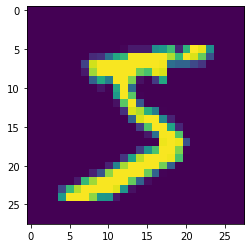

In [107]:
# Load the dataset
data = np.load('mnist1k.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_train_bin = data['X_train_bin']
y_train_bin = data['y_train_bin']
X_val_bin = data['X_val_bin']
y_val_bin = data['y_val_bin']
N_train = len(y_train)
N_val = len(y_val)
plt.imshow(X_train[0,:].reshape(28,28))
print(y_train[0])

## Implementing a $k$Nearest-Neighbor

#### Q1. Implement a class that encapsulate the squared euclidean distance ($\| x_1 - x_2 \|^2$) using the Distance parent class.


In [108]:
class Distance():
    '''
    trains this distance function on a training set
    '''
    def fit(self, X, y):
        pass
    
    '''
    returns the distance between the sets X1 and X2:
    X1 is n x d (n samples of dimension d)
    X2 is m x d (n samples of dimension d)
    output is n x m (distance matrix)
    '''
    def predict(self, X1, X2):
        pass

In [109]:
class L2Distance(Distance):
    def __init__(self):
        super().__init__()
    
    def predict(self, X1, X2):
        X1_norm = jnp.linalg.norm(X1, axis=1)**2
        X2_norm = jnp.linalg.norm(X2, axis=1)**2
        scal = jnp.dot(X1, X2.T)
        dist = X1_norm[:,None] + X2_norm[None,:] - 2*scal
        return dist

Q2. Implement a $k$NearestNeighbor class that relies on a Distance object to find the neighbors. It also trains the distance (by default, does nothing).

In [110]:
class KNN():
    def __init__(self, distance, k=1):
        self.distance = distance
        self.k = k
    
    '''
    trains the distance and memorizes the training set
    X: n x d (n samples of dimension d)
    y: n (n labels)
    '''
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.distance.fit(self.X, self.y)
    
    '''
    predict the set of samples
    '''
    def predict(self, X):
        dist = self.distance.predict(X, self.X)
        neighbours = jnp.argsort(dist, axis=1)
        neighbours_labels = self.y[neighbours[:,:self.k]]
        y_pred = np.apply_along_axis(jnp.bincount, axis=1, arr=neighbours_labels, minlength=10)
        y_pred = jnp.argmax(y_pred, axis=1)
        return y_pred
      

We first try on the reduced training set to check that our code works. 

In [111]:
knn = KNN(L2Distance(), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

training error 0.07500000298023224
val error 0.16200000047683716


#### Q3. Implement a trainable $\ell_2$ distance function relying. I performs a linear projection $P$ such that the distance between similar samples is minimized, trained using gradient descent

$$ \min_P \sum_{x, x_p, y = y_p} \|Px - Px_p\|^2 $$

In [112]:
class L2MinDistance(Distance):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.dist = L2Distance()
    
    @staticmethod
    def loss(P, X, y, dist):
        P_x = jnp.matmul(X,P)
        D = dist(P_x, P_x)
        T_F = (y[:,None] == y[None,:])
        P_sum = jnp.mean(D * T_F, axis = [0,1])
        return P_sum
    
    @staticmethod
    def update(P, X, y, dist, eta=0.01):
        l, dp = jax.value_and_grad(L2MinDistance.loss, argnums=0)(P, X, y, dist)
        return l, P - eta*dp
        
    def fit(self, X, y):
        loss = []
        for i in range(100):
            l, self.P = L2MinDistance.update(self.P, X, y, self.dist.predict)
            loss.append(l)
            #print(l)
        plt.plot(loss)
        return 
    
    def predict(self, X1, X2):
        P_x1 = jnp.matmul(X1, self.P)
        P_x2 = jnp.matmul(X2, self.P)
        D = self.dist.predict(P_x1, P_x2)
        return D      

training error 0.11600000411272049
val error 0.30400002002716064


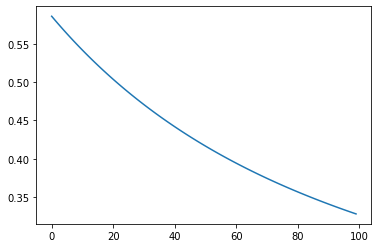

In [113]:
knn = KNN(L2MinDistance(784, 64), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

It is pretty good even if the algorithm tends to project every point at the same place : we could improve it.

## Contrastive loss

Next, we want to mitigate the tendancy of only minimizing the distance to collapse all samples to the same location

#### Q3. Code a trainable distance function that minimizes the distance between related samples up to a margin and maximizes the distance between unrelated samples up to a margin

$$\min_p \sum_{x, x_p, y = y_p} \max(0, \|Px - Px_p\|^2 - \alpha) - \lambda \sum_{x, x_p, y \neq y_p} \max(0, \beta - \|Px - Px_p\|^2) $$

Plot the loss value as the gradient descent progresses

In [114]:
class L2ContrastiveDistance(Distance):
    def __init__(self, input_dim, output_dim, alpha=0.1, beta= 0.7, lambd=0.5):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.dist = L2Distance()
        self.alpha = alpha
        self.beta = beta
        self.lambd = lambd
    
    @staticmethod
    def loss(P, X, y, alpha, beta, lambd, dist):
        P_x = jnp.matmul(X,P)
        D = dist(P_x, P_x)
        D_a = jnp.max(D - alpha, 0)
        D_b = jnp.max(beta - D, 0)
        T_F = (y[:,None] == y[None,:])
        Pa_sum = (D_a * T_F).mean()
        Pb_sum = (D_b * T_F).mean()
        return Pa_sum - lambd * Pb_sum
    
    @staticmethod
    def update(P, X, y, alpha, beta, lambd, dist, eta=0.05):
        l, dp = jax.value_and_grad(L2ContrastiveDistance.loss, argnums=0)(P, X, y, alpha, beta, lambd, dist)
        return l, P - eta*dp
        
    def fit(self, X, y):
        loss = []
        for i in range(10):
            l, self.P = L2ContrastiveDistance.update(self.P, X, y, self.alpha, self.beta, self.lambd, self.dist.predict)
            loss.append(l)
            #print(l)
        plt.plot(loss)
        return
    
    def predict(self, X1, X2):
        P_x1 = jnp.matmul(X1, self.P)
        P_x2 = jnp.matmul(X2, self.P)
        D = self.dist.predict(P_x1, P_x2)
        return D        
        

training error 0.14100000262260437
val error 0.42600002884864807


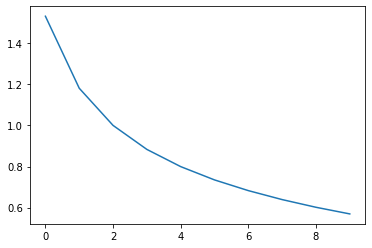

In [115]:
knn = KNN(L2ContrastiveDistance(784, 64), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

The result is acceptable, however we observe that we have to train very few time, otherwise it overfits really quickly.
With 1000 iterations, the result is really bad.


## Triplet loss

Since $k$NN is in nature using a ranking approach by sorting the samples, we will know consider a loss function that enforces the order of the samples rather than their absolute distance values.

$$ \min_P \sum_{x, x_p, x_n, y = y_p, y \neq y_n} \max(0, \alpha + \|x - x_p\|^2 - \|x - x_n\|^2) $$

#### Q4. Code the triplet loss based trainable distance function.

In [116]:
class L2TripletDistance(Distance):
    def __init__(self, input_dim, output_dim, alpha=0.3):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.dist = L2Distance()
        self.alpha = alpha
    
    @staticmethod
    def loss(P, X, y, alpha, dist):
        P_X = jnp.matmul(X, P)
        D1 = dist(P_X, P_X)
        D = (D1[:,:,None] - D1[:,None,:] + alpha)
        D = jnp.max(D,0)
        T_ = (y[:,None] == y[None,:])
        F_ = (y[:,None] != y[None,:])
        Sum = (D * T_[:,:,None] * F_[:,None,:]).mean()
        return Sum
    
    @staticmethod
    def update(P, X, y, alpha, dist, eta=0.05):
        l, dp = jax.value_and_grad(L2TripletDistance.loss, argnums=0)(P, X, y, alpha, dist)
        return l, P - eta*dp
        
    def fit(self, X, y):
        loss = []
        for i in range(100):
            l, self.P = L2TripletDistance.update(self.P, X, y, self.alpha, self.dist.predict)
            loss.append(l)
            #print(l)
        plt.plot(loss)
        return
    
    def predict(self, X1, X2):
        P_x1 = jnp.matmul(X1, self.P)
        P_x2 = jnp.matmul(X2, self.P)
        D = self.dist.predict(P_x1, P_x2)
        return D

training error 0.5300000309944153
val error 0.7460000514984131


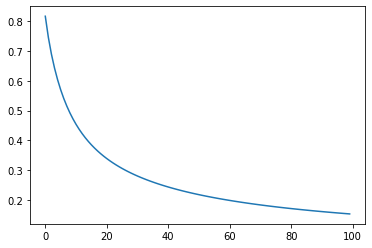

In [117]:
knn = KNN(L2TripletDistance(784, 64), k=3)
knn.fit(X_train[:500], y_train[:500])
y_hat = knn.predict(X_train[:500])
err = (y_hat != y_train[:500]).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

I trained the model only on the first 500 items, otherwise I had a problem of memory.
With 500, the result is pretty good and better than it used to be with the other distances.

#### Q5. Perform a cross validation on the margin, the number of dimensions and the number of neighbors.

In [118]:
def randomSplit(key, X, y, train_part=0.8):
    n = X.shape[0]
    n_train = int(train_part*n); n_test = n - n_train
    p = jax.random.permutation(key, n)
    X_train = X[p[0:n_train], :]
    y_train = y[p[0:n_train]]
    X_val = X[p[n_train:],:] 
    y_val = y[p[n_train:]]
    return X_train, y_train, X_val, y_val

1
6
11
16


<ErrorbarContainer object of 3 artists>

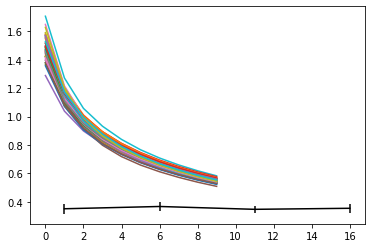

In [119]:
key = jax.random.PRNGKey(32)
l = []
for k in range(1, 21, 5):
    print(k)
    lk = []
    for s in range(10):
        key, skey = jax.random.split(key)
        X_train, y_train, X_val, y_val = randomSplit(skey, np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
        knn = KNN(L2ContrastiveDistance(784, 64), k=3)
        knn.fit(X_train[:500], y_train[:500])
        y_hat = knn.predict(X_val)
        lk.append((y_hat != y_val).mean())
    l.append(lk)
l = jnp.asarray(l)
plt.errorbar(range(1,21,5), l.mean(axis=1), l.std(axis=1), fmt='-k')

## visualization

In order to visualize what is happening during the metric learning, we can interpret the projections of $P$ as images.

#### Q6. Extract the projection from a trained distance and plot each projector associated with each output space component as an image.

In [120]:
P = 
for i in range (len(P)):
    plt.imshow(P[:,i].reshape(28,28))


NameError: ignored

*Analyze your results in this box*